<a href="https://colab.research.google.com/github/Hanton-MENEZ/BigData/blob/main/Livrable_2_Traitement_d'images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import des paquets requis
import os
import cv2
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, Conv2DTranspose
from keras import regularizers
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

#variables
path_to_archive = 'drive/MyDrive/dataset/Dataset Livrable 2.zip'
decompression_folder = 'images'
path_to_images = 'images/Dataset'
img_width = 180
img_height = 180
channels = 3
input_shape = (img_height, img_width, channels)
epochs = 30
batch_size = 32

In [ ]:
# decompression des données
with zipfile.ZipFile(path_to_archive, 'r') as zip_ref:
      zip_ref.extractall(decompression_folder)

In [ ]:
def add_noise(image, noise_factor=0.5, blur_factor=1.5):
  # Générer une matrice de bruit aléatoire de la même taille que l'image
  noise = np.random.normal(loc=0, scale=1, size=image.shape)
  # Mélanger l'image d'origine avec le bruit
  noisy_image = cv2.addWeighted(image.astype(np.float64), 1 - noise_factor, noise, noise_factor, 0)
  # Assurer que les valeurs des pixels restent dans la plage [0, 255]
  noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
  # Appliquer le flou gaussien à l'image
  noisy_image = cv2.GaussianBlur(image, (0, 0), blur_factor)


  return noisy_image

def load_images_from_folder(folder_path):
  images = []
  noisy_imgaes = []
  for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)
    if os.path.isfile(img_path):
      # Charger l'image en utilisant OpenCV
      img = cv2.imread(img_path)

      # Redimensionner l'image
      img = cv2.resize(img, (img_height, img_width))
      # Convertir l'image en format RGB (si elle n'est pas déjà en RGB)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # Ajouter l'image en tant que tableau NumPy à la liste
      images.append(img)

      # Bruite l'image
      noisy_img = add_noise(img)
      noisy_imgaes.append(noisy_img)

      img = img.reshape((1,) + img.shape)

      # crée des images supplémentaires au vu de la petite taille du dataset
      augmented_images = []
      for batch in datagen.flow(img, batch_size=1):
        images.append(batch.reshape(img.shape[1:]))  # Supprimer la dimension ajoutée
        noisy_imgaes.append(add_noise(batch.reshape(img.shape[1:])))
        augmented_images.append(batch.reshape(img.shape[1:]))
        if len(augmented_images) >= 12:  # Nombre arbitraire d'images augmentées à générer
          break

  return np.array(images), np.array(noisy_imgaes)

# Créer un générateur d'images avec augmentation de données
datagen = ImageDataGenerator(
rotation_range=40,  # Angle de rotation maximal en degrés
width_shift_range=0.2,  # Fraction de décalage maximal horizontal
height_shift_range=0.2,  # Fraction de décalage maximal vertical
fill_mode='nearest'  # Mode de remplissage pour la translation
)

images, noisy_images = load_images_from_folder(path_to_images)

# Passage des valeurs de pixel de [0;250]
images, noisy_images = images/255, noisy_images/255

print(images.shape, noisy_images.shape)

(1924, 180, 180, 3) (1924, 180, 180, 3)


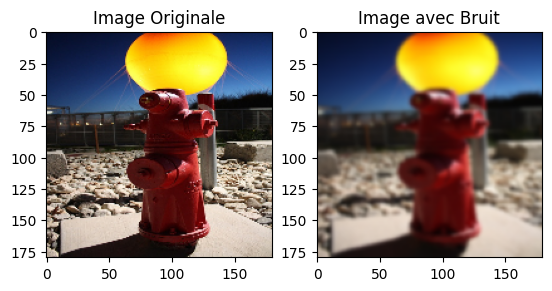

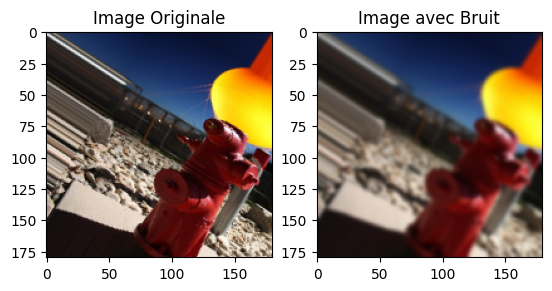

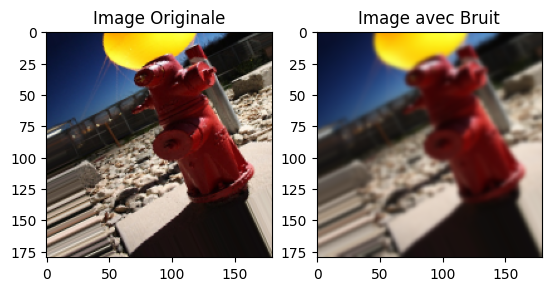

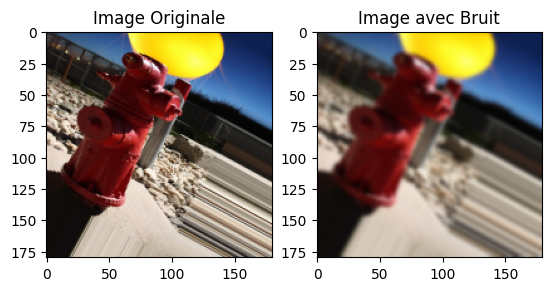

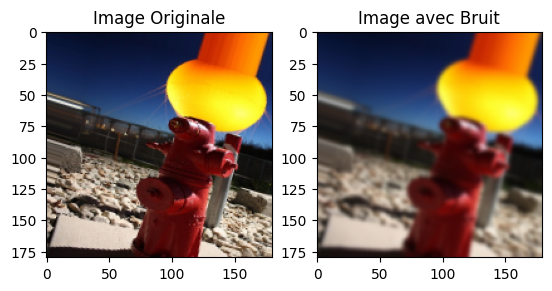

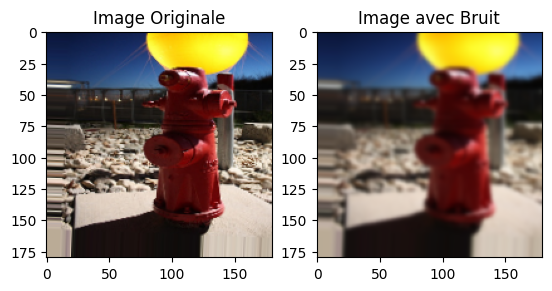

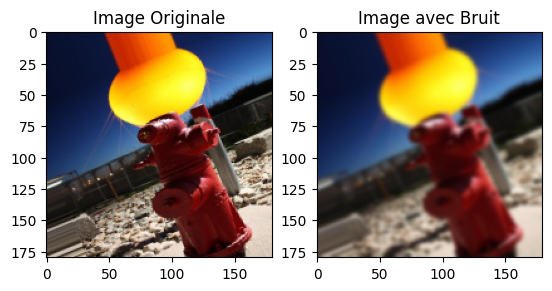

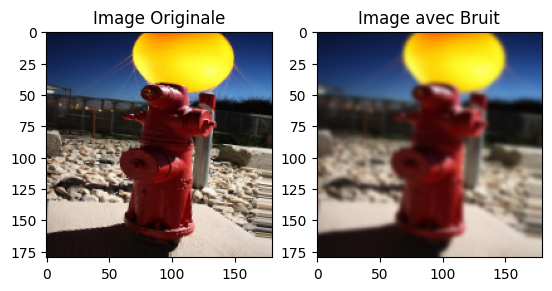

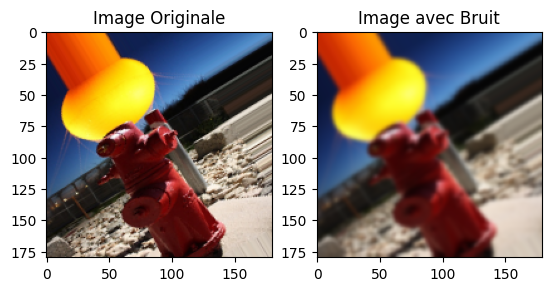

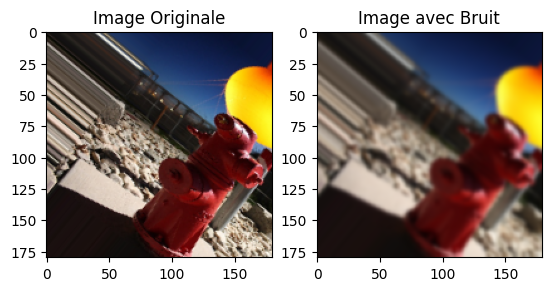

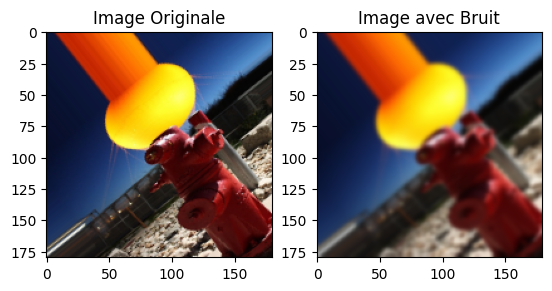

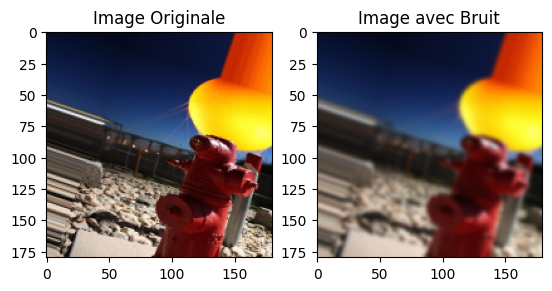

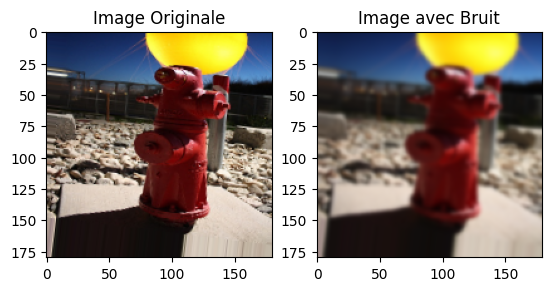

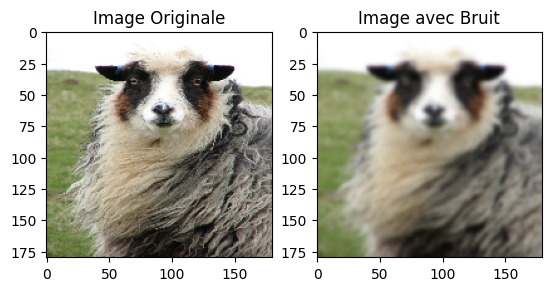

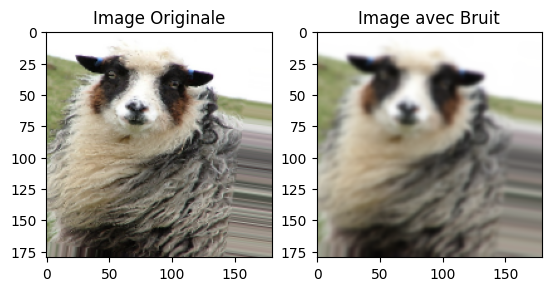

In [ ]:
#affichage des images

for i in range(15):
  # Afficher l'image originale
  plt.subplot(1, 2, 1)
  plt.imshow(images[i])
  plt.title('Image Originale')

  # Afficher l'image avec bruit
  plt.subplot(1, 2, 2)
  plt.imshow(noisy_images[i])
  plt.title('Image avec Bruit')

  plt.show()

In [ ]:
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Mean Squared Error loss pour la reconstruction d'images

    return autoencoder

# Construire l'auto-encodeur
autoencoder = build_autoencoder(input_shape)

# Afficher un résumé du modèle
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        36928 

In [ ]:
noisy_images_train, noisy_images_test = train_test_split(noisy_images, test_size=0.20, random_state=42)
images_train, images_test = train_test_split(images, test_size=0.20, random_state=42)

In [ ]:
# Entraîner l'auto-encodeur
history = autoencoder.fit(noisy_images_train, images_train,
                epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(noisy_images_test, images_test))

Epoch 1/30
49/49 [==============================] - 239s 5s/step - loss: 0.0337 - val_loss: 0.0098
Epoch 2/30
49/49 [==============================] - 235s 5s/step - loss: 0.0085 - val_loss: 0.0076
Epoch 3/30
49/49 [==============================] - 234s 5s/step - loss: 0.0073 - val_loss: 0.0069
Epoch 4/30
49/49 [==============================] - 239s 5s/step - loss: 0.0063 - val_loss: 0.0062
Epoch 5/30
49/49 [==============================] - 229s 5s/step - loss: 0.0057 - val_loss: 0.0053
Epoch 6/30
49/49 [==============================] - 236s 5s/step - loss: 0.0049 - val_loss: 0.0048
Epoch 7/30
49/49 [==============================] - 229s 5s/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/30
49/49 [==============================] - 238s 5s/step - loss: 0.0045 - val_loss: 0.0043
Epoch 9/30
49/49 [==============================] - 230s 5s/step - loss: 0.0042 - val_loss: 0.0042
Epoch 10/30
49/49 [==============================] - 228s 5s/step - loss: 0.0041 - val_loss: 0.0041
Epoch 11/

1/1 [==============================] - 0s 159ms/step


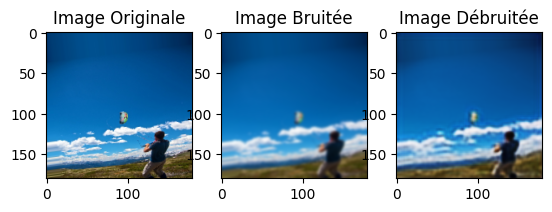

In [ ]:
# Débruitage d'une image
noisy_image = noisy_images_test[0:2]
denoised_image = autoencoder.predict(noisy_image)

# Afficher l'image originale, l'image bruitée et l'image débruitée
plt.subplot(1, 3, 1)
plt.imshow(images_test[1])
plt.title('Image Originale')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image[1])
plt.title('Image Bruitée')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image[1])
plt.title('Image Débruitée')

plt.show()

In [ ]:
# Sauvegarde du model
autoencoder.save_weights('./autoencoder-77.5.h5')

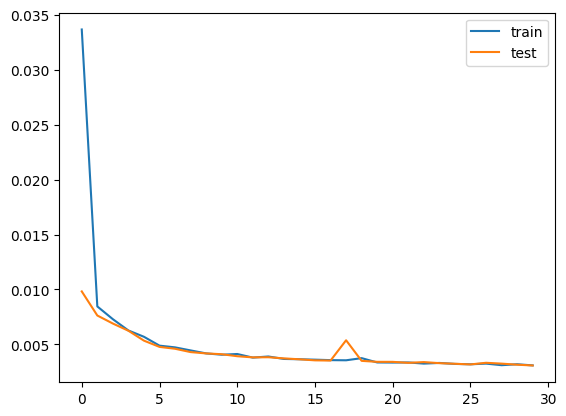

In [ ]:
# Visualisation des pertes d'apprentissage (Train) et de validation (Test)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

# Calculer PSNR
psnr_r = peak_signal_noise_ratio(images_test[1][:, :, 0], denoised_image[1][:, :, 0])
psnr_g = peak_signal_noise_ratio(images_test[1][:, :, 1], denoised_image[1][:, :, 1])
psnr_b = peak_signal_noise_ratio(images_test[1][:, :, 2], denoised_image[1][:, :, 2])

# Prendre la moyenne des PSNR pour chaque canal
psnr_value = np.mean([psnr_r, psnr_g, psnr_b])

# Calculer SSIM
ssim_r, _ = structural_similarity(images_test[1][:, :, 0], denoised_image[1][:, :, 0], full=True)
ssim_g, _ = structural_similarity(images_test[1][:, :, 1], denoised_image[1][:, :, 1], full=True)
ssim_b, _ = structural_similarity(images_test[1][:, :, 2], denoised_image[1][:, :, 2], full=True)

# Prendre la moyenne des SSIM pour chaque canal
ssim_value = np.mean([ssim_r, ssim_g, ssim_b])

# Aplatir les matrices d'images en vecteurs
original_flat = images_test[1].flatten()
reconstructed_flat = denoised_image[1].flatten()

# Calculer le coefficient de corrélation de Pearson
pearson_corr, _ = pearsonr(original_flat, reconstructed_flat)

# Aplatir les matrices d'images en vecteurs
original_flat = original_flat.reshape(1, -1)
reconstructed_flat = reconstructed_flat.reshape(1, -1)

# Calculer la similarité cosinus
cosine_sim = cosine_similarity(original_flat, reconstructed_flat)[0, 0]

# Affichage des métriques
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")
print(f"Similarité Cosinus : {cosine_sim}")
print(f"Coefficient de Pearson : {pearson_corr}")

PSNR: 27.00884599638427
SSIM: 0.8445569950889218
Similarité Cosinus : 0.9953286647796631
Coefficient de Pearson : 0.9869413192781072


Peak Signal-to-Noise Ratio (PSNR) :
* Plus le PSNR est élevé, meilleure est la qualité de la reconstruction.
* PSNR est exprimé en décibels (dB), et une augmentation de 10 dB * équivaut généralement à une amélioration significative de la qualité perçue.
* Une valeur de PSNR de 20 dB à 30 dB est généralement considérée comme acceptable, tandis que des valeurs supérieures à 30 dB indiquent une qualité élevée.

Structural Similarity Index (SSIM) :
* SSIM est compris entre -1 et 1, où 1 indique une correspondance parfaite entre les images.
* Plus le SSIM est proche de 1, meilleure est la qualité de la reconstruction.
* Une valeur de SSIM supérieure à 0.9 est généralement considérée comme excellente, entre 0.8 et 0.9 comme bonne, entre 0.7 et 0.8 comme acceptable, et en dessous de 0.7 comme médiocre.

Interprétation du Coefficient de Pearson :
* Une valeur de +1 indique une corrélation linéaire parfaite (les images sont identiques).
* Une valeur de −1 indique une corrélation linéaire négative parfaite (les images sont inverses l'une de l'autre).
* Une valeur proche de 00 indique une faible corrélation linéaire.

Interprétation de la Similarité Cosinus :
* Une valeur de 11 indique une similarité parfaite entre les vecteurs (les images sont identiques).
* Une valeur de 00 indique une absence de similarité entre les vecteurs (les images sont complètement différentes).
* Une valeur proche de 11 indique une certaine similarité directionnelle.